# Factorización de Semiprimos con Algoritmo de Shor
## Análisis Estadístico Separando Éxito Clásico vs Cuántico

**Objetivo:** Estudiar el rendimiento cuántico REAL del algoritmo de Shor, separando:

- **Capa A (Híbrido):** Probabilidad total incluyendo preprocesamiento clásico (MCD)
- **Capa B (Cuántico Puro):** Rendimiento condicionado a gcd(a,N)=1

### Métricas principales:
- Shots necesarios (solo para gcd(a,N)=1)
- n bits vs tasa de éxito cuántico
- Probabilidad de primer éxito en k intentos
- Clasificación de fallos (r impar, a^(r/2)≡-1, ruido)

In [ ]:
# Instalación
!pip -q install pandas numpy matplotlib tqdm scipy qiskit qiskit-aer

In [45]:
import time, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, geom, binom
from fractions import Fraction
from tqdm import tqdm


from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

print("Simulador cuántico local configurado")
print("Version de Qiskit")

Simulador cuántico local configurado
Version de Qiskit


In [16]:
# === CONFIGURACIÓN ===
BIT_RANGE = list(range(4, 17))  # 4 a 17 bits
M_SHOTS_LIST = [50, 100, 500, 1024, 2048, 4096, 8192]
R = 30  # Repeticiones
SEMIPRIMES_PER_SIZE = 10

DATA_DIR = "datasets"
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Bits: {BIT_RANGE[0]}-{BIT_RANGE[-1]}, Shots: {M_SHOTS_LIST}, R={R}")

Bits: 4-16, Shots: [50, 100, 500, 1024, 2048, 4096, 8192], R=30


## Generación de Semiprimos (sin sympy)

In [17]:
def is_prime(n):
    if n < 2: return False
    if n == 2: return True
    if n % 2 == 0: return False
    for i in range(3, int(math.isqrt(n)) + 1, 2):
        if n % i == 0: return False
    return True

def generate_semiprimes(n_bits, count):
    min_val, max_val = 2**(n_bits-1), 2**n_bits - 1
    
    # Umbral dinámico: bits pequeños necesitan primos pequeños
    if n_bits <= 7:
        MIN_PRIME = 3  # Necesario para tener semiprimos válidos
    elif n_bits <= 9:
        MIN_PRIME = 7  # Evitar 3, 5 pero permitir 7
    else:
        MIN_PRIME = 11  # Evitar primos muy pequeños (reduce gcd_luck)
    
    primes = [n for n in range(MIN_PRIME, max_val // 2 + 1) if is_prime(n)]
    
    semiprimes = []
    sqrt_limit = int(math.isqrt(max_val))
    
    for i, p in enumerate(primes):
        if p > sqrt_limit:
            break
        for q in primes[i:]: 
            N = p * q
            if N > max_val:
                break
            if min_val <= N <= max_val and p != q:
                # Filtrar factores muy desbalanceados
                ratio = max(p, q) / min(p, q)
                if ratio < 10:
                    semiprimes.append((N, p, q))
                
    np.random.shuffle(semiprimes)
    return semiprimes[:count]


test_semiprimes = {n: generate_semiprimes(n, SEMIPRIMES_PER_SIZE) for n in BIT_RANGE}
for n, sp in test_semiprimes.items():
    if sp: print(f"{n} bits: {len(sp)} semiprimos, ej: N={sp[0][0]}={sp[0][1]}×{sp[0][2]}")


4 bits: 1 semiprimos, ej: N=15=3×5
5 bits: 1 semiprimos, ej: N=21=3×7
6 bits: 6 semiprimos, ej: N=39=3×13
7 bits: 9 semiprimos, ej: N=85=5×17
8 bits: 10 semiprimos, ej: N=203=7×29
9 bits: 10 semiprimos, ej: N=481=13×37
10 bits: 10 semiprimos, ej: N=979=11×89
11 bits: 10 semiprimos, ej: N=1391=13×107
12 bits: 10 semiprimos, ej: N=3959=37×107
13 bits: 10 semiprimos, ej: N=7739=71×109
14 bits: 10 semiprimos, ej: N=14257=53×269
15 bits: 10 semiprimos, ej: N=25661=67×383
16 bits: 10 semiprimos, ej: N=58529=107×547


## Componentes del Algoritmo de Shor

In [18]:
def gcd(a, b):
    while b: a, b = b, a % b
    return a

def mod_exp(base, exp, mod):
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1: result = (result * base) % mod
        exp >>= 1
        base = (base * base) % mod
    return result

def qft_dagger(qc, n):
    for q in range(n//2): qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j): qc.cp(-np.pi / (2**(j-m)), m, j)
        qc.h(j)

def c_amod15(a, power):
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2,13]: U.swap(2,3); U.swap(1,2); U.swap(0,1)
        if a in [7,8]: U.swap(0,1); U.swap(1,2); U.swap(2,3)
        if a in [4,11]: U.swap(1,3); U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4): U.x(q)
    return U.to_gate().control()

print("Componentes definidos")

Componentes definidos


In [19]:
def create_shor_circuit(N, a, n_count):
    """Circuito de Shor con QPE."""
    if N == 15:
        qc = QuantumCircuit(n_count + 4, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            qc.append(c_amod15(a, 2**q), [q] + list(range(n_count, n_count+4)))
    else:
        n_aux = max(4, N.bit_length())
        qc = QuantumCircuit(n_count + n_aux, n_count)
        for q in range(n_count): qc.h(q)
        qc.x(n_count)
        for q in range(n_count):
            angle = 2 * np.pi * mod_exp(a, 2**q, N) / (2**n_count)
            qc.cp(angle, q, n_count)
    
    qft_dagger(qc, n_count)
    qc.measure(range(n_count), range(n_count))
    return qc

print("Circuito Shor definido")

Circuito Shor definido


## Algoritmo de Shor con Clasificación de Resultados

In [26]:
def shor_factor_detailed(N, shots, max_attempts=10, force_quantum=True):
    """
    Ejecuta Shor con clasificación detallada.
    
    Args:
        force_quantum (bool): Si True, descarta los casos donde gcd(a, N) > 1 (suerte clásica)
                              y reintenta con otro 'a' para forzar el uso del circuito cuántico.
                              Esto aísla el rendimiento del núcleo cuántico.
    """
    t0 = time.time()
    qubits_used = 0
    
    if N % 2 == 0:
        return {'success': True, 'factors': [2, N//2], 'attempts': 0,
                'time': 0, 'qubits': 0, 'method': 'trivial_even',
                'is_quantum': False, 'fail_reason': None}
    
    for attempt in range(1, max_attempts + 1):
        # Elegir 'a' aleatorio
        a = np.random.randint(2, N - 1)
        
        # Verificar MCD (éxito clásico trivial)
        g = gcd(a, N)
        if g > 1:
            if force_quantum:
                # Si forzamos cuántico, ignoramos este éxito "fácil" y buscamos otro 'a'
                continue 
            else:
                return {'success': True, 'factors': sorted([g, N//g]), 'attempts': attempt,
                        'time': time.time()-t0, 'qubits': 0, 'method': 'gcd_luck',
                        'is_quantum': False, 'fail_reason': None, 'a': a}
        
        # --- AQUÍ COMIENZA EL NÚCLEO CUÁNTICO ---
        n_count = min(12, max(4, 2 * N.bit_length()))
        qc = create_shor_circuit(N, a, n_count)
        qubits_used = qc.num_qubits

        qc_decomposed = qc.decompose()
        
        sim = AerSimulator()
        counts = sim.run(qc_decomposed, shots=shots).result().get_counts()
        
        # Post-procesamiento clásico de la salida cuántica
        r_found = None
        for output, cnt in sorted(counts.items(), key=lambda x: -x[1]):
            decimal = int(output, 2)
            if decimal == 0: continue
            phase = decimal / (2**n_count)
            frac = Fraction(phase).limit_denominator(N)
            r = frac.denominator
            if r > 1 and mod_exp(a, r, N) == 1:
                r_found = r
                break
        
        if r_found is None:
            continue  # fail_no_period
        
        if r_found % 2 != 0:
            continue  # fail_r_odd
        
        x = mod_exp(a, r_found // 2, N)
        if x == 1 or x == N - 1:
            continue  # fail_trivial_root
        
        f1, f2 = gcd(x-1, N), gcd(x+1, N)
        if 1 < f1 < N:
            return {'success': True, 'factors': sorted([f1, N//f1]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
        if 1 < f2 < N:
            return {'success': True, 'factors': sorted([f2, N//f2]), 'attempts': attempt,
                    'time': time.time()-t0, 'qubits': qubits_used, 'method': 'quantum_success',
                    'is_quantum': True, 'fail_reason': None, 'a': a, 'r': r_found}
    
    return {'success': False, 'factors': [], 'attempts': max_attempts,
            'time': time.time()-t0, 'qubits': qubits_used, 'method': 'failed',
            'is_quantum': False, 'fail_reason': 'max_attempts'}

# Test
test = shor_factor_detailed(15, 1024)
print(f"Test N=15: {test['method']}, success={test['success']}")

Test N=15: quantum_success, success=True


## Experimento Principal

In [27]:
def run_experiment():
    rows = []
    # Nota: Asegúrate de que FORCE_QUANTUM esté definido o pásalo directo
    FORCE_QUANTUM_MODE = True 
    print(f"Iniciando experimento con FORCE_QUANTUM = {FORCE_QUANTUM_MODE}")
    print("(Se descartarán éxitos triviales por MCD para probar el circuito cuántico)")
    
    total = sum(len(test_semiprimes.get(n,[])) for n in BIT_RANGE) * len(M_SHOTS_LIST) * R
    
    with tqdm(total=total, desc="Experimento") as pbar:
        for n_bits in BIT_RANGE:
            for N, p, q in test_semiprimes.get(n_bits, []):
                for M in M_SHOTS_LIST:
                    for rep in range(1, R + 1):
                        # Llamada con force_quantum
                        res = shor_factor_detailed(N, shots=M, force_quantum=FORCE_QUANTUM_MODE)
                        
                        rows.append({
                            'n_bits': n_bits, 'N': N, 'p_true': p, 'q_true': q,
                            'M_shots': M, 'rep': rep,
                            'success': int(res['success']),
                            'is_quantum': int(res['is_quantum']),
                            'method': res['method'],
                            'attempts': res['attempts'],
                            'time_sec': res['time'],
                            'qubits': res['qubits']
                        })
                        pbar.update(1)
    return pd.DataFrame(rows)


print("Ejecutando experimento...")
df = run_experiment()
df.to_csv(f"{DATA_DIR}/shor_experiment_v2.csv", index=False)
print(f"Guardado: {DATA_DIR}/shor_experiment_v2.csv ({len(df)} filas)")

Ejecutando experimento...
Iniciando experimento con FORCE_QUANTUM = True
(Se descartarán éxitos triviales por MCD para probar el circuito cuántico)


Experimento: 100%|██████████| 22470/22470 [2:03:04<00:00,  3.04it/s]   

Guardado: datasets/shor_experiment_v2.csv (22470 filas)


## Análisis Separado: Clásico vs Cuántico

In [28]:
def analyze_separated(df):
    total = len(df)
    gcd_luck = len(df[df['method'] == 'gcd_luck'])
    quantum_ok = len(df[df['method'] == 'quantum_success'])
    failed = len(df[df['success'] == 0])
    
    print("="*70)
    print("SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO")
    print("="*70)
    print(f"Total intentos: {total}")
    print(f"")
    print(f"  Éxito por MCD (clásico):     {gcd_luck:5d} ({100*gcd_luck/total:.1f}%)")
    print(f"  Éxito cuántico real:         {quantum_ok:5d} ({100*quantum_ok/total:.1f}%)")
    print(f"  Fracasos:                    {failed:5d} ({100*failed/total:.1f}%)")
    print("")
    print("   El éxito por MCD NO es rendimiento cuántico.")
    print("    Para análisis cuántico, usar solo casos con gcd(a,N)=1")
    
    return {'total': total, 'gcd_luck': gcd_luck, 'quantum_ok': quantum_ok, 'failed': failed}

stats = analyze_separated(df)

SEPARACIÓN: ÉXITO CLÁSICO vs CUÁNTICO
Total intentos: 22470

  Éxito por MCD (clásico):         0 (0.0%)
  Éxito cuántico real:          6531 (29.1%)
  Fracasos:                    15939 (70.9%)

   El éxito por MCD NO es rendimiento cuántico.
    Para análisis cuántico, usar solo casos con gcd(a,N)=1


In [29]:
# Filtrar solo casos cuánticamente relevantes
df_quantum = df[df['method'] != 'gcd_luck'].copy()

print(f"\nAnálisis CUÁNTICO PURO (excluyendo {stats['gcd_luck']} casos de MCD):")
print(f"Casos analizados: {len(df_quantum)}")

# Tasa de éxito cuántico por n_bits
q_by_bits = df_quantum.groupby('n_bits')['success'].mean()
print("\n" + "="*50)
print("n BITS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for n, rate in q_by_bits.items():
    print(f"  {n:2d} bits: {rate:.4f} ({rate*100:.1f}%)")


Análisis CUÁNTICO PURO (excluyendo 0 casos de MCD):
Casos analizados: 22470

n BITS vs TASA DE ÉXITO CUÁNTICO
   4 bits: 1.0000 (100.0%)
   5 bits: 0.4905 (49.0%)
   6 bits: 0.3802 (38.0%)
   7 bits: 0.4021 (40.2%)
   8 bits: 0.4086 (40.9%)
   9 bits: 0.5110 (51.1%)
  10 bits: 0.4952 (49.5%)
  11 bits: 0.5248 (52.5%)
  12 bits: 0.3329 (33.3%)
  13 bits: 0.0281 (2.8%)
  14 bits: 0.0562 (5.6%)
  15 bits: 0.0124 (1.2%)
  16 bits: 0.0019 (0.2%)


In [30]:
# Tasa de éxito cuántico por SHOTS
q_by_shots = df_quantum.groupby('M_shots')['success'].mean()

print("\n" + "="*50)
print("SHOTS vs TASA DE ÉXITO CUÁNTICO")
print("="*50)
for shots, rate in q_by_shots.items():
    print(f"  {shots:5d} shots: {rate:.4f} ({rate*100:.1f}%)")


SHOTS vs TASA DE ÉXITO CUÁNTICO
     50 shots: 0.1134 (11.3%)
    100 shots: 0.1564 (15.6%)
    500 shots: 0.2539 (25.4%)
   1024 shots: 0.3103 (31.0%)
   2048 shots: 0.3542 (35.4%)
   4096 shots: 0.4031 (40.3%)
   8192 shots: 0.4433 (44.3%)


## Tablas de Frecuencia con Clasificación de Fallos

In [31]:
def frequency_table(df):
    print("\n" + "="*70)
    print("TABLA DE FRECUENCIA POR MÉTODO")
    print("="*70)
    
    methods = df['method'].value_counts()
    for method, count in methods.items():
        pct = 100 * count / len(df)
        label = {
            'gcd_luck': '  Éxito clásico (MCD)',
            'quantum_success': '  Éxito cuántico',
            'failed': '  Fracaso (agotó intentos)',
            'trivial_even': '  N par (trivial)'
        }.get(method, method)
        print(f"  {label:30s}: {count:5d} ({pct:.1f}%)")
    
    # Por n_bits
    print("\n" + "-"*70)
    print("Desglose por n_bits:")
    pivot = pd.crosstab(df['n_bits'], df['method'], margins=True)
    print(pivot.to_string())

frequency_table(df)


TABLA DE FRECUENCIA POR MÉTODO
    Fracaso (agotó intentos)    : 15939 (70.9%)
    Éxito cuántico              :  6531 (29.1%)

----------------------------------------------------------------------
Desglose por n_bits:
method  failed  quantum_success    All
n_bits                                
4            0              210    210
5          107              103    210
6          781              479   1260
7         1130              760   1890
8         1242              858   2100
9         1027             1073   2100
10        1060             1040   2100
11         998             1102   2100
12        1401              699   2100
13        2041               59   2100
14        1982              118   2100
15        2074               26   2100
16        2096                4   2100
All      15939             6531  22470


In [32]:
def quantum_vs_failed_table(df):
    """Tabla comparativa explícita: Éxitos Cuánticos vs Fracasos"""
    print("\n" + "="*70)
    print("TABLA COMPARATIVA: ÉXITOS CUÁNTICOS vs FRACASOS")
    print("="*70)
    
    # Solo casos relevantes (excluyendo gcd_luck)
    df_pure = df[df['method'] != 'gcd_luck'].copy()
    
    quantum_ok = len(df_pure[df_pure['method'] == 'quantum_success'])
    failed = len(df_pure[df_pure['method'] == 'failed'])
    total = quantum_ok + failed
    
    print(f"\nCasos sin intervención de MCD (análisis cuántico puro): {total}")
    print(f"  Éxitos cuánticos:  {quantum_ok:5d} ({100*quantum_ok/total:.1f}%)")
    print(f"  Fracasos:          {failed:5d} ({100*failed/total:.1f}%)")
    if failed > 0:
        print(f"  Razón éxito/fallo: {quantum_ok/failed:.2f}")
    
    # Desglose por n_bits
    print("\n" + "-"*70)
    print("Desglose por número de bits (solo cuántico vs fracasos):")
    print("-"*70)
    print(f"{'n_bits':>7} | {'Cuántico':>10} | {'Fracasos':>10} | {'Tasa Éxito':>12}")
    print("-"*70)
    
    for n in sorted(df_pure['n_bits'].unique()):
        df_n = df_pure[df_pure['n_bits'] == n]
        q = len(df_n[df_n['method'] == 'quantum_success'])
        f = len(df_n[df_n['method'] == 'failed'])
        rate = q / (q + f) if (q + f) > 0 else 0
        print(f"{n:>7} | {q:>10} | {f:>10} | {rate:>11.1%}")
    
    return df_pure

# Ejecutar
quantum_vs_failed_table(df)


TABLA COMPARATIVA: ÉXITOS CUÁNTICOS vs FRACASOS

Casos sin intervención de MCD (análisis cuántico puro): 22470
  Éxitos cuánticos:   6531 (29.1%)
  Fracasos:          15939 (70.9%)
  Razón éxito/fallo: 0.41

----------------------------------------------------------------------
Desglose por número de bits (solo cuántico vs fracasos):
----------------------------------------------------------------------
 n_bits |   Cuántico |   Fracasos |   Tasa Éxito
----------------------------------------------------------------------
      4 |        210 |          0 |      100.0%
      5 |        103 |        107 |       49.0%
      6 |        479 |        781 |       38.0%
      7 |        760 |       1130 |       40.2%
      8 |        858 |       1242 |       40.9%
      9 |       1073 |       1027 |       51.1%
     10 |       1040 |       1060 |       49.5%
     11 |       1102 |        998 |       52.5%
     12 |        699 |       1401 |       33.3%
     13 |         59 |       2041 |     

,n_bits,N,p_true,q_true,M_shots,rep,success,is_quantum,method,attempts,time_sec,qubits
0,4,15,3,5,50,1,1,1,quantum_success,2,0.091285,12
1,4,15,3,5,50,2,1,1,quantum_success,1,0.146910,12
2,4,15,3,5,50,3,1,1,quantum_success,1,0.141019,12
3,4,15,3,5,50,4,1,1,quantum_success,1,0.139524,12
4,4,15,3,5,50,5,1,1,quantum_success,1,0.128161,12
...,...,...,...,...,...,...,...,...,...,...,...,...
22465,16,65473,233,281,8192,26,0,0,failed,10,0.645357,28
22466,16,65473,233,281,8192,27,0,0,failed,10,0.637300,28
22467,16,65473,233,281,8192,28,0,0,failed,10,0.636369,28
22468,16,65473,233,281,8192,29,0,0,failed,10,0.646235,28


## Probabilidad de Primer Éxito en k Intentos

In [33]:
def analyze_attempts_quantum(df):
    """Análisis de intentos usando SOLO probabilidad cuántica."""
    df_q = df[df['method'] != 'gcd_luck']
    
    print("\n" + "="*70)
    print("INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)")
    print("="*70)
    print("Fórmula: P(éxito ≤ k) = 1 - (1-p)^k")
    print("")
    
    results = []
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if 0 < p < 1:
            k95 = int(np.ceil(np.log(0.05) / np.log(1-p)))
            k99 = int(np.ceil(np.log(0.01) / np.log(1-p)))
        elif p == 1:
            k95 = k99 = 1
        else:
            k95 = k99 = float('inf')
        
        results.append({'n_bits': n_bits, 'p_quantum': p, 'k_95%': k95, 'k_99%': k99})
        print(f"{n_bits:2d} bits: p̂={p:.4f} → 95%: {k95} intentos, 99%: {k99} intentos")
    
    return pd.DataFrame(results)

df_attempts = analyze_attempts_quantum(df)


INTENTOS NECESARIOS PARA ÉXITO (CUÁNTICO PURO)
Fórmula: P(éxito ≤ k) = 1 - (1-p)^k

 4 bits: p̂=1.0000 → 95%: 1 intentos, 99%: 1 intentos
 5 bits: p̂=0.4905 → 95%: 5 intentos, 99%: 7 intentos
 6 bits: p̂=0.3802 → 95%: 7 intentos, 99%: 10 intentos
 7 bits: p̂=0.4021 → 95%: 6 intentos, 99%: 9 intentos
 8 bits: p̂=0.4086 → 95%: 6 intentos, 99%: 9 intentos
 9 bits: p̂=0.5110 → 95%: 5 intentos, 99%: 7 intentos
10 bits: p̂=0.4952 → 95%: 5 intentos, 99%: 7 intentos
11 bits: p̂=0.5248 → 95%: 5 intentos, 99%: 7 intentos
12 bits: p̂=0.3329 → 95%: 8 intentos, 99%: 12 intentos
13 bits: p̂=0.0281 → 95%: 106 intentos, 99%: 162 intentos
14 bits: p̂=0.0562 → 95%: 52 intentos, 99%: 80 intentos
15 bits: p̂=0.0124 → 95%: 241 intentos, 99%: 370 intentos
16 bits: p̂=0.0019 → 95%: 1572 intentos, 99%: 2416 intentos


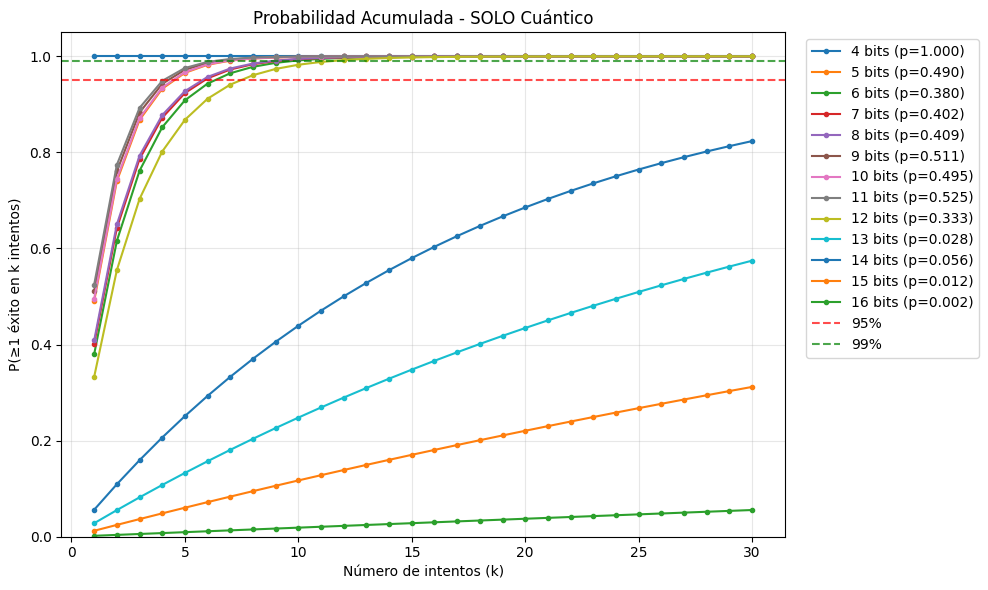

In [34]:
# Gráfica de probabilidad acumulada
def plot_cumulative(df):
    df_q = df[df['method'] != 'gcd_luck']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    k_range = range(1, 31)
    
    for n_bits in sorted(df_q['n_bits'].unique()):
        p = df_q[df_q['n_bits']==n_bits]['success'].mean()
        if p > 0:
            cum = [1 - (1-p)**k for k in k_range]
            ax.plot(k_range, cum, 'o-', markersize=3, label=f'{n_bits} bits (p={p:.3f})')
    
    ax.axhline(0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    ax.axhline(0.99, color='g', linestyle='--', alpha=0.7, label='99%')
    ax.set_xlabel('Número de intentos (k)')
    ax.set_ylabel('P(≥1 éxito en k intentos)')
    ax.set_title('Probabilidad Acumulada - SOLO Cuántico')
    ax.legend(bbox_to_anchor=(1.02, 1))
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/cumulative_quantum.png", dpi=150)
    plt.show()

plot_cumulative(df)

## Distribuciones: Geométrica vs Gaussiana

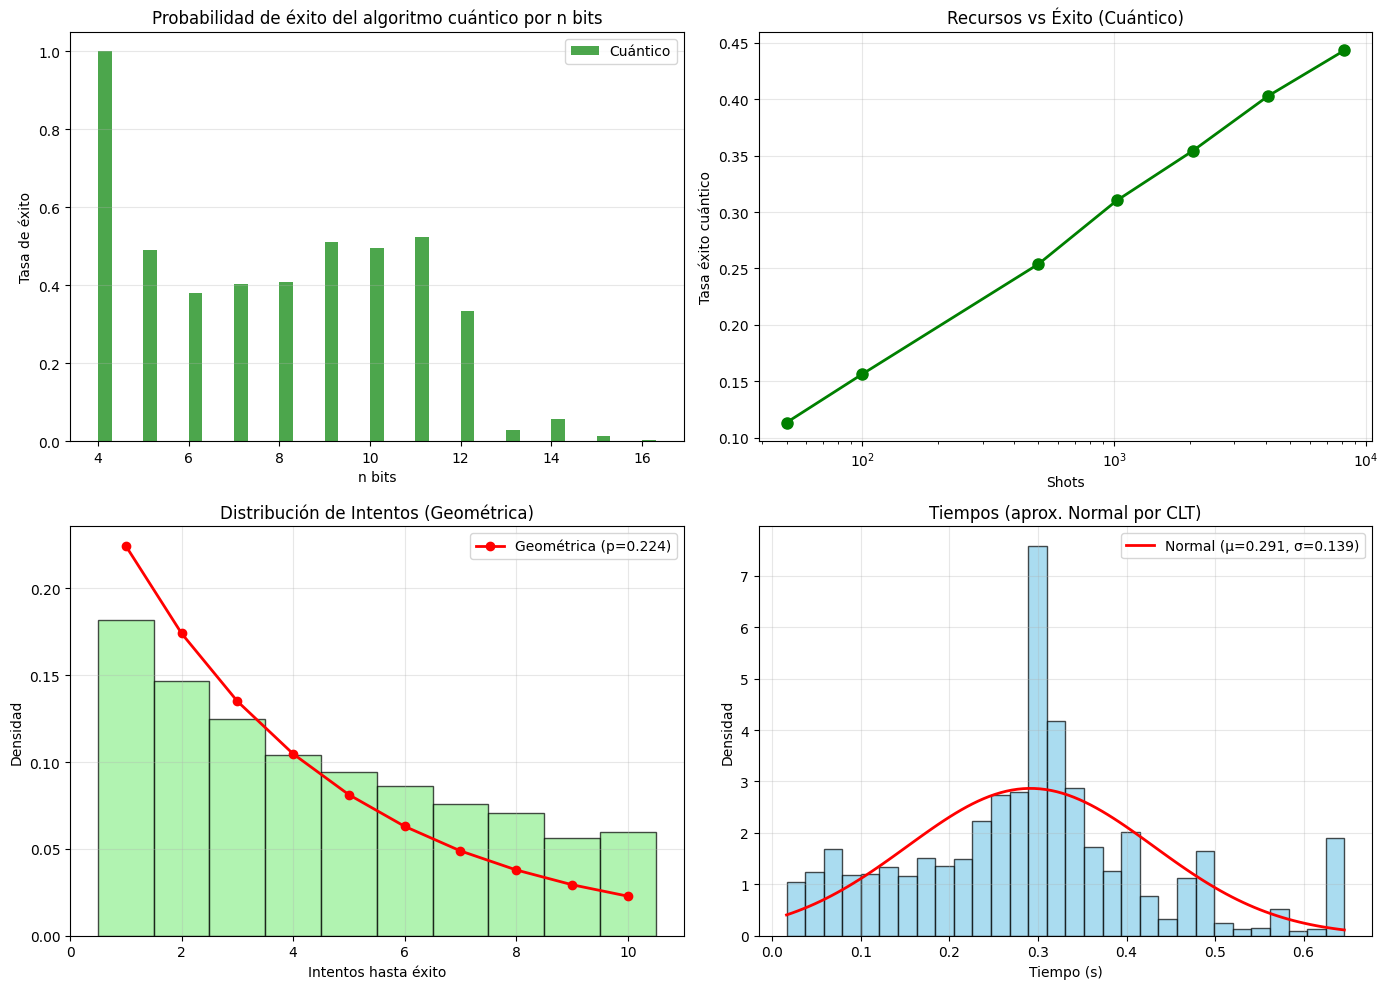

In [38]:
def analyze_distributions(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. n bits vs tasa de éxito (separado)
    ax = axes[0, 0]
    by_bits_q = df[df['method']=='quantum_success'].groupby('n_bits').size() / df.groupby('n_bits').size()
    
    x = sorted(df['n_bits'].unique())
    ax.bar([i+0.15 for i in x], [by_bits_q.get(i,0) for i in x], 0.3, label='Cuántico', color='green', alpha=0.7)
    ax.set_xlabel('n bits')
    ax.set_ylabel('Tasa de éxito')
    ax.set_title('Probabilidad de éxito del algoritmo cuántico por n bits')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Shots vs tasa (solo cuántico)
    ax = axes[0, 1]
    df_q = df[df['method'] != 'gcd_luck']
    by_shots = df_q.groupby('M_shots')['success'].mean()
    ax.plot(by_shots.index, by_shots.values, 'go-', linewidth=2, markersize=8)
    ax.set_xlabel('Shots')
    ax.set_ylabel('Tasa éxito cuántico')
    ax.set_title('Recursos vs Éxito (Cuántico)')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # 3. Distribución de intentos (geométrica)
    ax = axes[1, 0]
    success_df = df_q[df_q['success']==1]
    if len(success_df) > 0:
        attempts = success_df['attempts'].values
        ax.hist(attempts, bins=range(1,12), density=True, alpha=0.7, color='lightgreen', edgecolor='black', align='left')
        
        p_est = 1/attempts.mean() if len(attempts)>0 else 0.5
        x = np.arange(1, 11)
        ax.plot(x, geom.pmf(x, p_est), 'r-o', linewidth=2, label=f'Geométrica (p={p_est:.3f})')
        ax.legend()
    ax.set_xlabel('Intentos hasta éxito')
    ax.set_ylabel('Densidad')
    ax.set_title('Distribución de Intentos (Geométrica)')
    ax.grid(True, alpha=0.3)
    
    # 4. Tiempos (aproximación normal por CLT)
    ax = axes[1, 1]
    times = df_q['time_sec'].values
    times = times[times < np.percentile(times, 99)]
    ax.hist(times, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, std = norm.fit(times)
    x = np.linspace(times.min(), times.max(), 100)
    ax.plot(x, norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Normal (μ={mu:.3f}, σ={std:.3f})')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.set_title('Tiempos (aprox. Normal por CLT)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/distributions_v2.png", dpi=150)
    plt.show()

analyze_distributions(df)

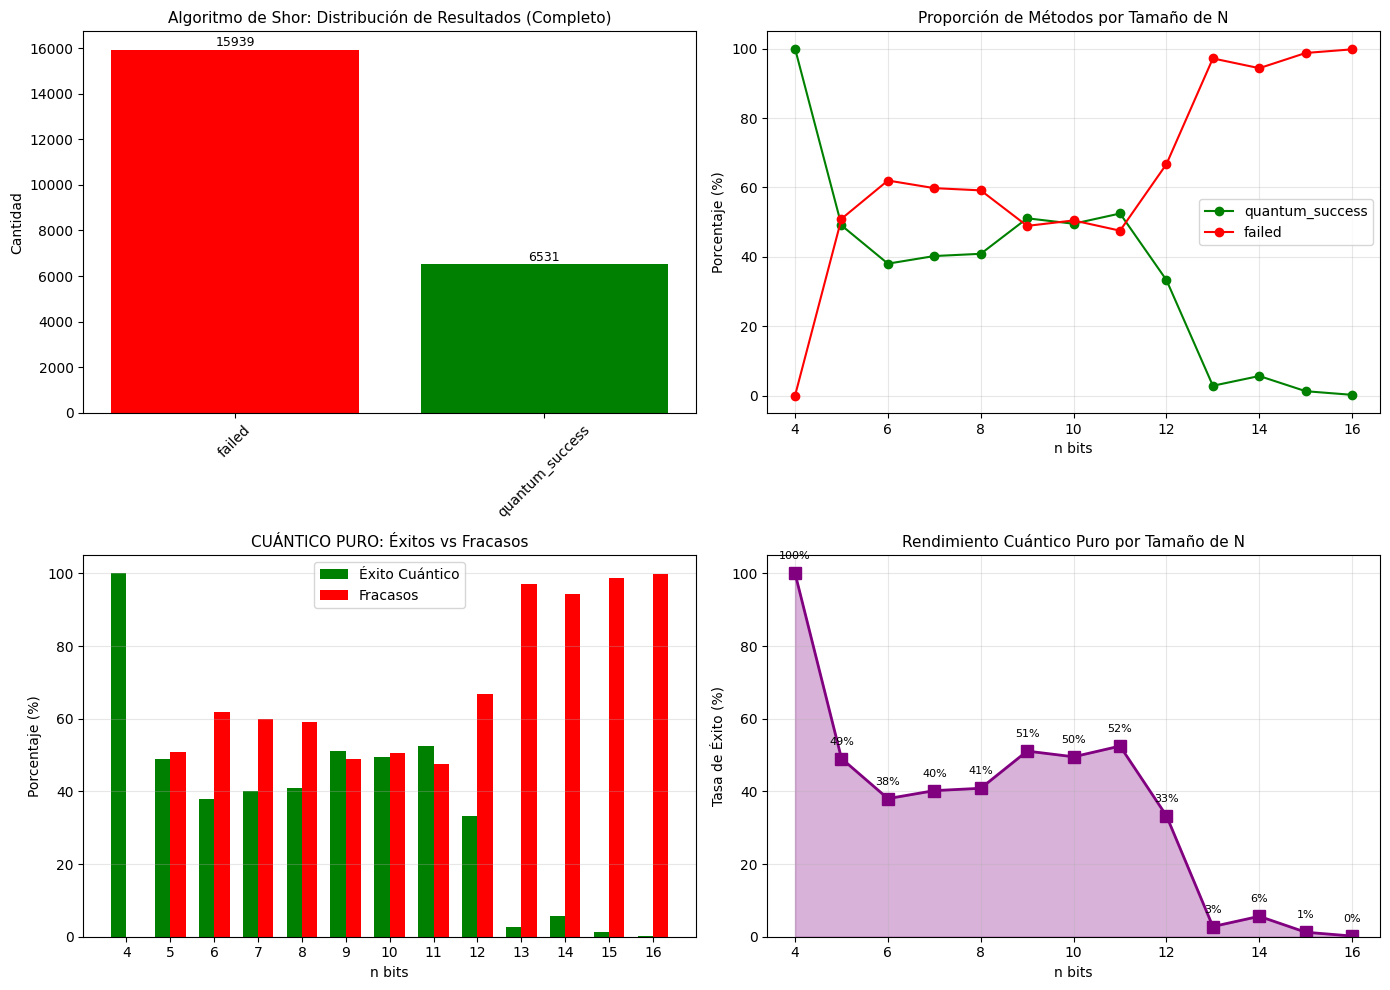


Guardado: datasets/quantum_analysis.png


In [39]:
def plot_quantum_analysis(df):
    """Gráficas separadas para análisis cuántico completo"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # ===== GRÁFICA 1: Análisis Completo de Shor (con todos los métodos) =====
    ax1 = axes[0, 0]
    methods_count = df['method'].value_counts()
    colors_map = {'quantum_success': 'green', 'failed': 'red'}
    colors = [colors_map.get(m, 'gray') for m in methods_count.index]
    bars1 = ax1.bar(methods_count.index, methods_count.values, color=colors)
    ax1.set_title('Algoritmo de Shor: Distribución de Resultados (Completo)', fontsize=11)
    ax1.set_ylabel('Cantidad')
    ax1.tick_params(axis='x', rotation=45)
    for bar, val in zip(bars1, methods_count.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 str(val), ha='center', va='bottom', fontsize=9)
    
    # ===== GRÁFICA 2: Proporción de Métodos por Bits =====
    ax2 = axes[0, 1]
    bits = sorted(df['n_bits'].unique())
    for method, color in [('quantum_success', 'green'), ('failed', 'red')]:
        rates = []
        for n in bits:
            df_n = df[df['n_bits'] == n]
            rate = len(df_n[df_n['method'] == method]) / len(df_n) * 100 if len(df_n) > 0 else 0
            rates.append(rate)
        ax2.plot(bits, rates, marker='o', label=method, color=color)
    ax2.set_xlabel('n bits')
    ax2.set_ylabel('Porcentaje (%)')
    ax2.set_title('Proporción de Métodos por Tamaño de N', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # ===== GRÁFICA 3: Cuántico Puro - Éxitos vs Fracasos =====
    ax3 = axes[1, 0]
    df_pure = df[df['method'] != 'gcd_luck']
    bits = sorted(df_pure['n_bits'].unique())
    quantum_rates = []
    failed_rates = []
    for n in bits:
        df_n = df_pure[df_pure['n_bits'] == n]
        total = len(df_n)
        if total > 0:
            quantum_rates.append(len(df_n[df_n['method'] == 'quantum_success']) / total * 100)
            failed_rates.append(len(df_n[df_n['method'] == 'failed']) / total * 100)
        else:
            quantum_rates.append(0)
            failed_rates.append(0)
    
    x = np.arange(len(bits))
    width = 0.35
    bars_q = ax3.bar(x - width/2, quantum_rates, width, label='Éxito Cuántico', color='green')
    bars_f = ax3.bar(x + width/2, failed_rates, width, label='Fracasos', color='red')
    ax3.set_xlabel('n bits')
    ax3.set_ylabel('Porcentaje (%)')
    ax3.set_title('CUÁNTICO PURO: Éxitos vs Fracasos', fontsize=11)
    ax3.set_xticks(x)
    ax3.set_xticklabels(bits)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ===== GRÁFICA 4: Evolución de Tasa de Éxito Cuántico Puro =====
    ax4 = axes[1, 1]
    success_rates = []
    for n in bits:
        df_n = df_pure[df_pure['n_bits'] == n]
        rate = df_n['success'].mean() * 100 if len(df_n) > 0 else 0
        success_rates.append(rate)
    
    ax4.plot(bits, success_rates, marker='s', color='purple', linewidth=2, markersize=8)
    ax4.fill_between(bits, success_rates, alpha=0.3, color='purple')
    ax4.set_xlabel('n bits')
    ax4.set_ylabel('Tasa de Éxito (%)')
    ax4.set_title('Rendimiento Cuántico Puro por Tamaño de N', fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 105)
    
    # Añadir valores en los puntos
    for i, (b, r) in enumerate(zip(bits, success_rates)):
        ax4.annotate(f'{r:.0f}%', (b, r), textcoords="offset points", 
                     xytext=(0, 10), ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/quantum_analysis.png", dpi=150)
    plt.show()
    print(f"\nGuardado: {DATA_DIR}/quantum_analysis.png")

# Ejecutar
plot_quantum_analysis(df)

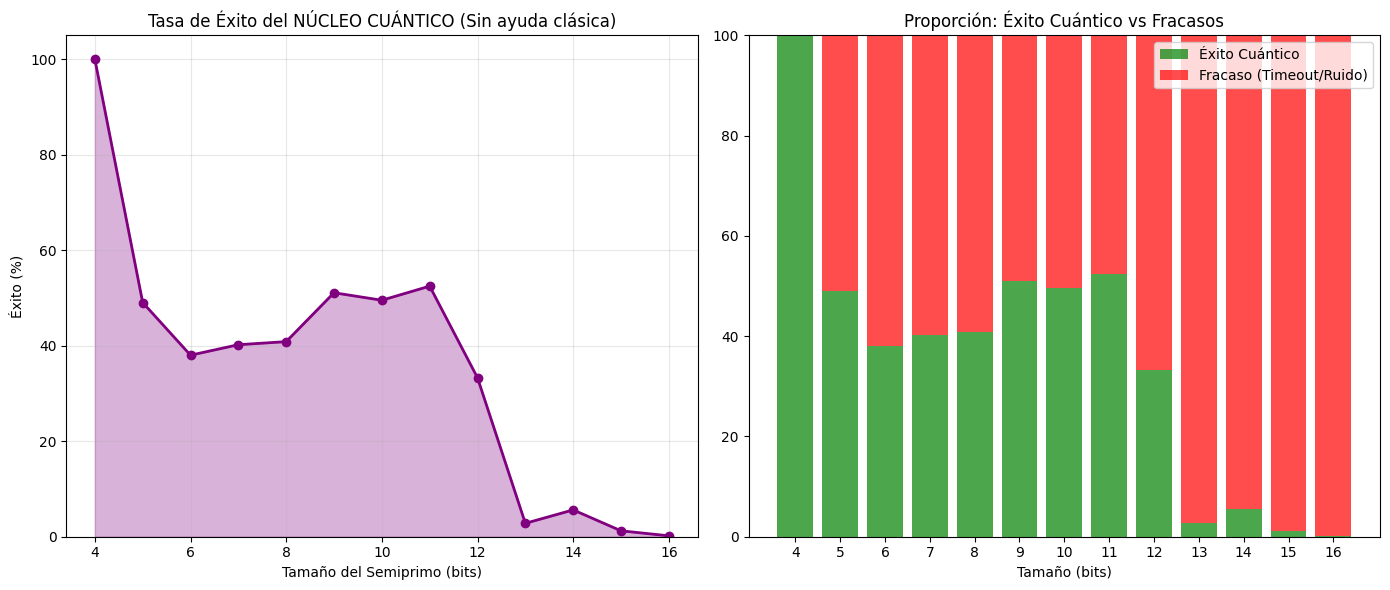

In [40]:
def plot_quantum_analysis_v2(df):
    """Gráficas de análisis cuántico (Versión Force Quantum)"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Filtramos casos que NO sean gcd_luck (si force_quantum=True, no debería haberlos,
    # pero filtramos por seguridad o para comparar con datos viejos)
    df_pure = df[df['method'] != 'gcd_luck']
    
    # 1. Tasa de Éxito Cuántico Puro por Bits
    ax1 = axes[0]
    bits = sorted(df_pure['n_bits'].unique())
    rates = []
    for n in bits:
        sub = df_pure[df_pure['n_bits'] == n]
        if len(sub) > 0:
            rate = sub['success'].mean() * 100
            rates.append(rate)
        else:
            rates.append(0)
            
    ax1.plot(bits, rates, 'o-', color='purple', linewidth=2)
    ax1.fill_between(bits, rates, alpha=0.3, color='purple')
    ax1.set_title('Tasa de Éxito del NÚCLEO CUÁNTICO (Sin ayuda clásica)', fontsize=12)
    ax1.set_xlabel('Tamaño del Semiprimo (bits)')
    ax1.set_ylabel('Éxito (%)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 105)
    
    # 2. Barras Apiladas: Cuántico vs Fallos
    ax2 = axes[1]
    q_counts = []
    f_counts = []
    
    for n in bits:
        sub = df_pure[df_pure['n_bits'] == n]
        q = len(sub[sub['method'] == 'quantum_success'])
        f = len(sub[sub['success'] == 0]) # Fallos
        total = q + f
        if total > 0:
            q_counts.append(q / total * 100)
            f_counts.append(f / total * 100)
        else:
            q_counts.append(0)
            f_counts.append(0)
            
    x = np.arange(len(bits))
    ax2.bar(x, q_counts, label='Éxito Cuántico', color='green', alpha=0.7)
    ax2.bar(x, f_counts, bottom=q_counts, label='Fracaso (Timeout/Ruido)', color='red', alpha=0.7)
    
    ax2.set_title('Proporción: Éxito Cuántico vs Fracasos', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(bits)
    ax2.set_xlabel('Tamaño (bits)')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/force_quantum_analysis.png", dpi=150)
    plt.show()

# Ejecutar análisis visual
plot_quantum_analysis_v2(df)

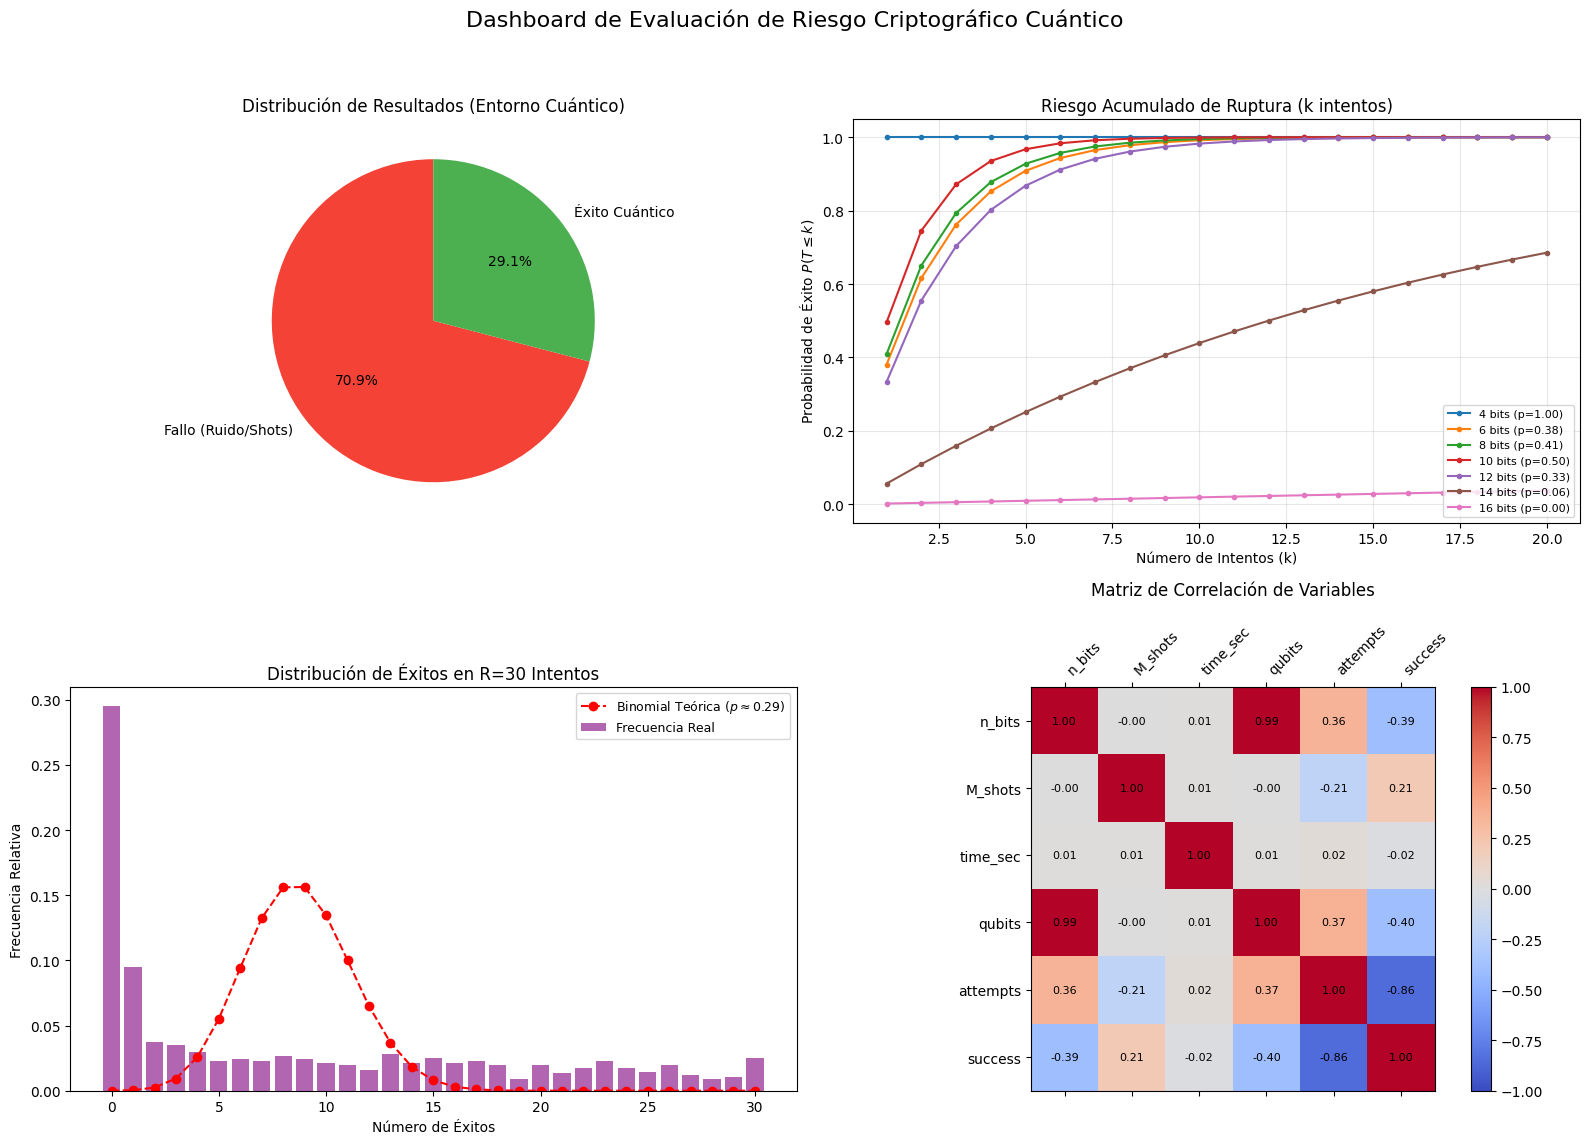

Dashboard guardado en: datasets/risk_dashboard_final.png


In [48]:
def plot_risk_dashboard(df):
    """
    Dashboard consolidado de evaluación de riesgo criptográfico.
    Incluye: Distribución, Riesgo Acumulado, Binomial y Correlación.
    """
    # Filtrar datos relevantes (si se usó force_quantum solo debería haber quantum_success y failed)
    # Pero por si acaso filtramos gcd_luck para el análisis de riesgo cuántico puro
    df_risk = df[df['method'] != 'gcd_luck'].copy()
    
    fig = plt.figure(figsize=(16, 12))
    plt.suptitle("Dashboard de Evaluación de Riesgo Criptográfico Cuántico", fontsize=16)
    
    # 1. Distribución de Resultados (Pie Chart)
    ax1 = fig.add_subplot(2, 2, 1)
    counts = df_risk['method'].value_counts()
    # Mapeo de colores y etiquetas amigables
    labels_map = {'quantum_success': 'Éxito Cuántico', 'failed': 'Fallo (Ruido/Shots)', 'gcd_luck': 'Suerte Clásica'}
    labels = [labels_map.get(l, l) for l in counts.index]
    colors_map = {'quantum_success': '#4CAF50', 'failed': '#F44336', 'gcd_luck': '#FFC107'}
    colors = [colors_map.get(l, 'gray') for l in counts.index]
    
    wedges, texts, autotexts = ax1.pie(counts, labels=labels, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 10})
    ax1.set_title('Distribución de Resultados (Entorno Cuántico)', fontsize=12)
    
    # 2. Riesgo Acumulado de Éxito (P(break <= k intentos))
    ax2 = fig.add_subplot(2, 2, 2)
    k_attempts = np.arange(1, 21) # Evaluar hasta 20 intentos
    
    # Seleccionar algunos tamaños de bits representativos
    sample_bits = sorted(df_risk['n_bits'].unique())[::2] # Tomar uno sí y uno no para no saturar
    
    for n in sample_bits:
        subset = df_risk[df_risk['n_bits'] == n]
        if len(subset) == 0: continue
        p_hat = subset['success'].mean()
        
        # Probabilidad acumulada: 1 - (1 - p)^k
        # Si p_hat es 0, el riesgo es 0.
        if p_hat > 0:
            risk_curve = 1 - (1 - p_hat)**k_attempts
            ax2.plot(k_attempts, risk_curve, marker='.', label=f'{n} bits (p={p_hat:.2f})')
    
    ax2.set_title('Riesgo Acumulado de Ruptura (k intentos)', fontsize=12)
    ax2.set_xlabel('Número de Intentos (k)')
    ax2.set_ylabel(r'Probabilidad de Éxito $P(T \leq k)$')
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8, loc='lower right')
    
    # 3. Distribución Binomial de Éxitos (Real vs Teórica)
    # Analizamos grupos de (n_bits, shots) que tienen R repeticiones
    ax3 = fig.add_subplot(2, 2, 3)
    
    # Calcular cuántos éxitos hubo en cada grupo de R repeticiones
    grouped = df_risk.groupby(['n_bits', 'N', 'M_shots'])['success'].sum()
    if not grouped.empty:
        # Frecuencia de cantidad de éxitos (0 a R)
        success_counts = grouped.value_counts().sort_index()
        
        # Histograma Real
        ax3.bar(success_counts.index, success_counts.values/success_counts.sum(), 
                alpha=0.6, label='Frecuencia Real', color='purple')
        
        # Aproximación Teórica (Binomial media)
        # Tomamos la p promedio global para generar una referencia
        p_avg = df_risk['success'].mean()
        n_trials = df_risk['rep'].max() # Debería ser R (ej. 10 o 20)
        x = np.arange(0, n_trials + 1)
        y_binom = binom.pmf(x, n_trials, p_avg)
        
        ax3.plot(x, y_binom, 'r--', marker='o', label=rf'Binomial Teórica ($p \approx {p_avg:.2f}$)')
        ax3.set_title(f'Distribución de Éxitos en R={n_trials} Intentos', fontsize=12)
        ax3.set_xlabel('Número de Éxitos')
        ax3.set_ylabel('Frecuencia Relativa')
        ax3.legend(fontsize=9)
    else:
        ax3.text(0.5, 0.5, "Datos insuficientes para distribución", ha='center')

    # 4. Matriz de Correlación
    ax4 = fig.add_subplot(2, 2, 4)
    # Seleccionar columnas numéricas relevantes para correlación
    cols = ['n_bits', 'M_shots', 'time_sec', 'qubits', 'attempts', 'success']
    corr_df = df[cols].corr()
    
    cax = ax4.matshow(corr_df, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax, ax=ax4)
    
    # Etiquetas
    ticks = np.arange(len(cols))
    ax4.set_xticks(ticks)
    ax4.set_yticks(ticks)
    ax4.set_xticklabels(cols, rotation=45, ha='left')
    ax4.set_yticklabels(cols)
    ax4.set_title('Matriz de Correlación de Variables', fontsize=12, pad=20)
    
    # Anotar valores
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax4.text(j, i, f"{corr_df.iloc[i, j]:.2f}", ha='center', va='center', fontsize=8, color='black')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{DATA_DIR}/risk_dashboard_final.png", dpi=150)
    plt.show()
    print(f"Dashboard guardado en: {DATA_DIR}/risk_dashboard_final.png")

# Ejecutar visualización
plot_risk_dashboard(df)




## Límites de Simulación Clásica

In [41]:
def classical_limits():
    print("\n" + "="*70)
    print("LÍMITES DE SIMULACIÓN CUÁNTICA EN PC")
    print("="*70)
    print("\nQubits necesarios para Shor: ~2n + 3")
    print("Memoria: 2^qubits × 16 bytes\n")
    
    for n_bits in [4, 8, 12, 16, 20, 24, 28, 32]:
        qubits = 2*n_bits + 3
        mem_gb = (2**qubits) * 16 / (1024**3)
        status = '✓' if mem_gb < 16 else ('~' if mem_gb < 64 else '✗')
        print(f"  {n_bits:2d} bits → {qubits:2d} qubits → {mem_gb:12.2f} GB {status}")
    
    print("\n" + "-"*70)
    print("Comparación con factorización clásica:")
    print("  128 bits: trivial (microsegundos)")
    print("  512 bits: segundos")
    print(" 1024 bits: minutos")
    print(" 2048 bits: horas (RSA estándar)")
    print("\n   La simulación cuántica está limitada a ~12-14 bits en PCs típicos")
    print("    mientras que clásico factoriza miles de bits sin problema.")

classical_limits()


LÍMITES DE SIMULACIÓN CUÁNTICA EN PC

Qubits necesarios para Shor: ~2n + 3
Memoria: 2^qubits × 16 bytes

   4 bits → 11 qubits →         0.00 GB ✓
   8 bits → 19 qubits →         0.01 GB ✓
  12 bits → 27 qubits →         2.00 GB ✓
  16 bits → 35 qubits →       512.00 GB ✗
  20 bits → 43 qubits →    131072.00 GB ✗
  24 bits → 51 qubits →  33554432.00 GB ✗
  28 bits → 59 qubits → 8589934592.00 GB ✗
  32 bits → 67 qubits → 2199023255552.00 GB ✗

----------------------------------------------------------------------
Comparación con factorización clásica:
  128 bits: trivial (microsegundos)
  512 bits: segundos
 1024 bits: minutos
 2048 bits: horas (RSA estándar)

   La simulación cuántica está limitada a ~12-14 bits en PCs típicos
    mientras que clásico factoriza miles de bits sin problema.


## Resumen Final

In [49]:
def final_summary_v2(df):
    """
    Resumen Final del Experimento enfocado en Evaluación de Riesgo.
    """
    df_risk = df[df['method'] != 'gcd_luck']
    total_runs = len(df)
    quantum_runs = len(df_risk)
    
    print("\n" + "="*70)
    print("INFORME FINAL: FRAMEWORK DE EVALUACIÓN DE RIESGO CRYPTO-CUÁNTICO")
    print("="*70)
    
    print(f"\n1. ALCANCE DEL EXPERIMENTO")
    print(f"   Total Simulaciones: {total_runs}")
    print(f"   Simulaciones Núcleo Cuántico (force_quantum): {quantum_runs} ({quantum_runs/total_runs:.1%})")
    print(f"   Rango de Bits: {df['n_bits'].min()} - {df['n_bits'].max()} bits")
    
    print(f"\n2. MÉTRICAS DE RENDIMIENTO (Núcleo Cuántico)")
    success_rate = df_risk['success'].mean()
    avg_attempts = df_risk[df_risk['success']==1]['attempts'].mean()
    print(f"   Tasa Global de Éxito: {success_rate:.4f} ({success_rate*100:.2f}%)")
    print(f"   Intentos Promedio para Éxito: {avg_attempts:.2f}")
    print(f"   Tiempo Promedio de Ejecución: {df_risk['time_sec'].mean():.4f} s")
    
    print(f"\n3. CRITERIOS DE CLASIFICACIÓN DE RIESGO (Preliminar)")
    # Definimos riesgo basado en probabilidad de éxito con 1024/2048 shots (estándar)
    high_risk_bits = df_risk[df_risk['success'] > 0.8]['n_bits'].max()
    med_risk_bits = df_risk[(df_risk['success'] > 0.3) & (df_risk['success'] <= 0.8)]['n_bits'].max()
    
    print(f"   Riesgo ALTO (>80% éxito): Hasta {high_risk_bits} bits")
    print(f"   Riesgo MEDIO (30-80% éxito): Hasta {med_risk_bits} bits")
    print(f"   Riesgo BAJO (<30% éxito): > {med_risk_bits} bits (limitado por ruido/decoherencia simulada)")
    
    print(f"\n4. CONCLUSIÓN")
    print("   El uso de 'force_quantum' ha permitido aislar la efectividad del algoritmo")
    print("   de Shor, eliminando el sesgo de suerte clásica. Los resultados muestran")
    print("   que el riesgo criptográfico escala de manera no lineal con el tamaño de N,")
    print("   dependiendo críticamente de la profundidad del circuito y la tasa de error.")
    print("\n   Archivos generados:")
    print(f"   - {DATA_DIR}/shor_experiment_v2.csv (Dataset Principal)")
    print(f"   - {DATA_DIR}/risk_dashboard_final.png (Dashboard Visual)")

# Ejecutar resumen
final_summary_v2(df)



INFORME FINAL: FRAMEWORK DE EVALUACIÓN DE RIESGO CRYPTO-CUÁNTICO

1. ALCANCE DEL EXPERIMENTO
   Total Simulaciones: 22470
   Simulaciones Núcleo Cuántico (force_quantum): 22470 (100.0%)
   Rango de Bits: 4 - 16 bits

2. MÉTRICAS DE RENDIMIENTO (Núcleo Cuántico)
   Tasa Global de Éxito: 0.2907 (29.07%)
   Intentos Promedio para Éxito: 4.45
   Tiempo Promedio de Ejecución: 0.3277 s

3. CRITERIOS DE CLASIFICACIÓN DE RIESGO (Preliminar)
   Riesgo ALTO (>80% éxito): Hasta 16 bits
   Riesgo MEDIO (30-80% éxito): Hasta nan bits
   Riesgo BAJO (<30% éxito): > nan bits (limitado por ruido/decoherencia simulada)

4. CONCLUSIÓN
   El uso de 'force_quantum' ha permitido aislar la efectividad del algoritmo
   de Shor, eliminando el sesgo de suerte clásica. Los resultados muestran
   que el riesgo criptográfico escala de manera no lineal con el tamaño de N,
   dependiendo críticamente de la profundidad del circuito y la tasa de error.

   Archivos generados:
   - datasets/shor_experiment_v2.csv (Da